In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
#from glob import glob
#cellhocs = sorted(glob('Cell_*.hoc'))
cellhoc = 'Cell_0.hoc'

In [5]:
simtime = 1000
stim_start = simtime / 2
stim_end = simtime
amp = 0.010

In [6]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def is_stem(sec):
    return 'soma' in str(sec.parentseg()) and not 'soma' in sec.name()

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

def get_stems(sec):
    return [s for s in sec.wholetree() if is_stem(s)]

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [8]:
def make_cell(hoc, morph=None):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    if morph:
        cmd = f'h.{name}("../morphology/", "{morph}")'
    else:
        cmd = f'h.{name}("../morphology/")'  # default morphology
    cell = eval(cmd)
    return cell

In [9]:
def make_nterm_cells(hoc, morph=None):
    cell = make_cell(hoc, morph)
    nterm = len([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    cells = [make_cell(hoc, morph) for i in range(nterm)]
    return cells

In [10]:
def make_nstem_cells(hoc, morph=None):
    cell = make_cell(hoc, morph)
    nstem = len([sec for sec in get_stems(cell.soma[0]) if 'dend' in sec.name()])
    cells = [make_cell(hoc, morph) for i in range(nstem)]
    return cells

In [11]:
cells = make_nstem_cells(cellhoc)
cells

[Cell_0[1], Cell_0[2], Cell_0[3], Cell_0[4], Cell_0[5], Cell_0[6], Cell_0[7]]

In [12]:
def set_term_stim(amp, cells):
    stimuli = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        tip = dend_tips[i]
        stim = h.IClamp(tip(1.0))
        stim.amp = amp
        stim.delay = stim_start
        stim.dur = stim_end - stim_start
        stimuli.append(stim)
    return stimuli

In [13]:
def set_stem_stim(amp, cells):
    stimuli = []
    for i, cell in enumerate(cells):
        dend_stems = sorted([sec for sec in get_stems(cell.soma[0]) if 'dend' in sec.name()])
        stem = dend_stems[i]
        stim = h.IClamp(stem(0.5))
        stim.amp = amp
        stim.delay = stim_start
        stim.dur = stim_end - stim_start
        stimuli.append(stim)
    return stimuli

In [14]:
def get_term_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        volt = h.Vector()
        volt.record(dend_tips[i](1.0)._ref_v)
        volts.append(volt)
    return volts

In [15]:
def get_stem_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        dend_stems = sorted([sec for sec in get_stems(cell.soma[0]) if 'dend' in sec.name()])
        volt = h.Vector()
        volt.record(dend_stems[i](0.5)._ref_v)
        volts.append(volt)
    return volts

In [16]:
def get_soma_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        volt = h.Vector()
        volt.record(cell.soma[0](0.5)._ref_v)
        volts.append(volt)
    return volts

In [19]:
stimuli = set_stem_stim(amp, cells)

In [20]:
volts = get_stem_volts(cells)
soma_volts = get_soma_volts(cells)

In [21]:
time = h.Vector()
time.record(h._ref_t)

Vector[3824]

In [22]:
h.v_init = -92.5
h.celsius = 35
h.tstop = simtime
cvode = h.CVode()
cvode.active(True)
h.dt = 0.025
h.run()

0.0

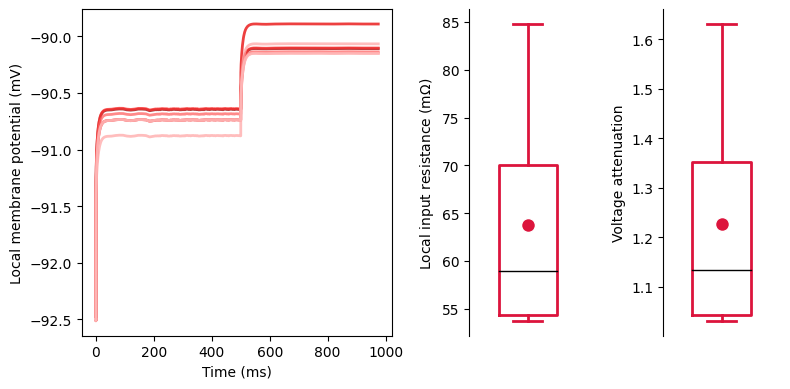

In [27]:
fig = plt.figure(figsize=(8, 4))

gs = fig.add_gridspec(1, 4)
ax = fig.add_subplot(gs[:2])

rin = []
att = []
color = 'darkred'
for volt, soma_volt in zip(volts, soma_volts):
    ax.plot(time, volt, color=color, linewidth=2, alpha=0.75)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Local membrane potential (mV)')
    color = lighten_color(color, 0.75)
    t = np.array(time)
    v = np.array(volt)
    s = np.array(soma_volt)
    sel = (t > simtime/2 *0.5) * (t < simtime/2)
    v1 = v[sel].mean()
    s1 = s[sel].mean()
    sel = (t > simtime *0.75)
    v2 = v[sel].mean()
    s2 = s[sel].mean()
    rin.append(abs((v2 - v1) / amp))
    att.append(abs((v2 - v1) / (s2 - s1)))

ax = fig.add_subplot(gs[2:3])

meanprops = dict(marker='o', markersize=10, markerfacecolor='crimson', markeredgecolor='w')
medianprops = dict(color='k')
flierprops = dict(marker='o', markerfacecolor=lighten_color('crimson'), markersize=10, markeredgecolor='w')
capprops = dict(color='crimson', linewidth=2)
boxprops = dict(color='crimson', linewidth=2)
whiskerprops = dict(color='crimson', linewidth=2)
ax.boxplot(rin, showmeans=True, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Local input resistance (m$\Omega$)')

ax = fig.add_subplot(gs[-1:])

ax.boxplot(att, showmeans=True, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Voltage attenuation')

fig.tight_layout()